In [1]:
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage, bpm2tempo
from musicnet.utils import notes_vocab, Track, get_train_ids, SyntheticTrack, PROJECT_ROOT_DIR, find_lr, create_vocab
from musicnet.preprocessing.wav_specs_and_notes.utils import Preprocessor
import numpy as np
import random
import pandas as pd
import subprocess
import os
from musicnet.params import config
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import scipy

2024-07-31 23:29:19.958499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:29:19.958592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:29:19.961027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:29:20.209115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
MIDI_OUT_DIR = os.path.join(PROJECT_ROOT_DIR, "data", "preprocessed", "synth_midi", "midi")
WAV_OUT_DIR = os.path.join(PROJECT_ROOT_DIR, "data", "preprocessed", "synth_midi", "wav")

In [3]:
os.makedirs(MIDI_OUT_DIR, 0o775, exist_ok=True)
os.makedirs(WAV_OUT_DIR, 0o775, exist_ok=True)

In [4]:
tps=100
min_note_ticks=1
max_note_ticks=100
max_silmultaneous_notes=5
sidechannel_sparsity=2
notes=list(range(20, 106))
# "Assisting" notes will be chosen from standard distribution with the mean at the main note
# and the standard distribution specified
notes_std=20
track_length_per_note=7200
velocity_min=32
velocity_max=96

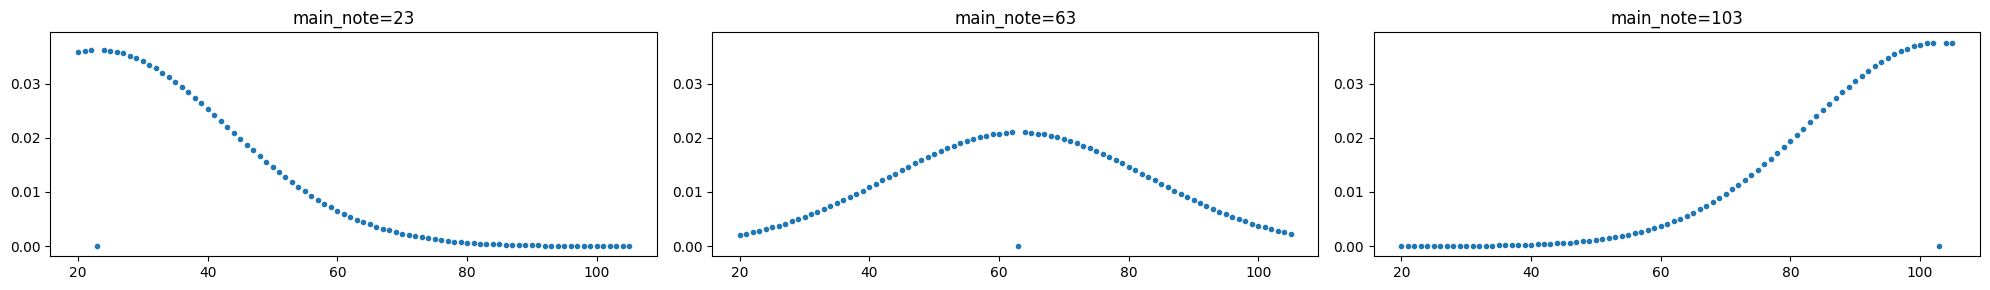

In [7]:
plt.figure(figsize=(20, 3))
# ax = plt.gca()
ax = None
examples = [notes[3], notes[len(notes)//2], notes[-3]]
for i, main_note in enumerate(examples):
    ax = plt.subplot(1, len(examples), i+1, sharey=ax)
    plt.title(f"main_note={main_note}")
    probabilities = np.array([scipy.stats.norm.pdf(n, loc=main_note, scale=notes_std) if n != main_note else 0 for n in notes])
    probabilities = probabilities / probabilities.sum() # Rescale so that the probabilities sum to 1
    plt.plot(notes, probabilities, "o", ms=3)
plt.tight_layout()
plt.show()

In [8]:
total_ticks = tps * track_length_per_note

In [44]:
class AccompanyingNotesGenerator:
    def __init__(self, main_note, batch_size=10000) -> None:
        self.main_note = main_note
        self.batch_size = batch_size
        self.batch = []
        p = np.array([scipy.stats.norm.pdf(n, loc=main_note, scale=notes_std) if n != main_note else 0 for n in notes])
        p = p / p.sum()
        self.p = p
    
    def next(self):
        if len(self.batch) == 0:
            self.batch = list(np.random.choice(notes, size=self.batch_size, p=self.p))
        return self.batch.pop()

def generate_channel_events(main_note, is_sidechannel=False, channel=0, program=0, sparsity=1):
    tick = 0
    events = [{ "tick": 0, "type": "program_change", "channel": channel, "program": program }]
    is_note_on = True
    generator = AccompanyingNotesGenerator(main_note)
    while tick < total_ticks:
        event = {
            "tick": tick,
            "channel": channel
        }
        if is_note_on:
            event["type"] = "note_on"
            event["velocity"] = random.randint(velocity_min, velocity_max)
            note = generator.next() if is_sidechannel else main_note
            event["note"] = note
        else:
            event["type"] = "note_off"
            event["note"] = note
        events.append(event)
        is_note_on = not is_note_on
        tick_delta = random.randint(min_note_ticks, max_note_ticks)
        if is_note_on:
            tick_delta *= sparsity
        tick += tick_delta
    return events

In [45]:
events = []
for note in notes[:1]:
    # Main channel events
    events = events + generate_channel_events(main_note=note, is_sidechannel=False, channel=0, sparsity=1)
    # "Side" channels events
    for c in range(1, max_silmultaneous_notes):
        events = events + generate_channel_events(main_note=note, is_sidechannel=True, channel=c, sparsity=sidechannel_sparsity)

In [46]:
events = pd.DataFrame(events).sort_values(by=["tick", "type"], ascending=[True, False]).reset_index(drop=True)
events["time"] = (events["tick"] - events["tick"].shift(1).fillna(0)).astype(int)
events["velocity"] = events["velocity"].astype(pd.Int8Dtype())
events["program"] = events["program"].astype(pd.Int8Dtype())
events["note"] = events["note"].astype(pd.Int8Dtype())
events = events.drop(columns=["tick"])
display(events[:10])
note_messages = [ Message(**{ k : v for k, v in event.items() if pd.notnull(v) }) for event in events.to_dict("records")]

,type,channel,program,velocity,note,time
0,program_change,0,0,<NA>,<NA>,0
1,note_on,0,<NA>,53,20,0
2,note_off,0,<NA>,<NA>,20,47
3,note_on,0,<NA>,46,20,82
4,note_off,0,<NA>,<NA>,20,70
5,note_on,0,<NA>,77,20,65
6,note_off,0,<NA>,<NA>,20,76
7,note_on,0,<NA>,33,20,1
8,note_off,0,<NA>,<NA>,20,66
9,note_on,0,<NA>,50,20,21


In [9]:
track_id = 4

In [48]:
file = MidiFile(ticks_per_beat=tps)
# Set tempo to 60 bpm, so 1 beat / second to simplify calculations
messages = [MetaMessage("set_tempo", tempo=bpm2tempo(60), time=0)]
messages += note_messages
track = MidiTrack(messages)
file.tracks.append(track)
midi_path = os.path.join(MIDI_OUT_DIR, f"{track_id}.midi")
file.save(midi_path)

In [12]:
# track = Track(get_train_ids()[-1])
# file = mido.MidiFile(track.get_midi_path())
# messages = list(file)

# messages[:50]

In [8]:
wav_path = os.path.join(WAV_OUT_DIR, f"{track_id}.wav")
subprocess.run(
    f"fluidsynth -F {wav_path} /usr/share/sounds/sf2/default-GM.sf2 {midi_path}",
    shell=True
)

NameError: name 'midi_path' is not defined

In [10]:
track = SyntheticTrack(track_id)

In [11]:
track.get_notes()[:20]

,note,channel,instrument,start,end,velocity
0,41,1,1,0.00,0.02,39.0
1,20,0,1,0.00,0.22,72.0
2,30,2,1,0.00,0.27,76.0
3,46,3,1,0.00,0.50,56.0
4,61,4,1,0.00,0.62,42.0
5,22,3,1,0.52,0.63,50.0
6,35,1,1,0.48,1.18,59.0
7,23,1,1,1.20,1.84,44.0
8,20,0,1,0.95,1.91,77.0
9,20,0,1,2.07,2.26,47.0


In [12]:
playing_notes = np.ones([total_ticks, max_silmultaneous_notes, 5]) * -1
for note in track.get_notes().to_dict("records"):
    s = int(note["start"] * 100)
    e = int(note["end"] * 100)
    duration = e - s
    playing_notes[s : e, note["channel"]] = np.concatenate([
        [[note["note"]]] * duration,
        [[note["velocity"]]] * duration,
        [[duration]] * duration,
        np.arange(1, duration+1).reshape(-1, 1),
        np.arange(duration-1, -1, -1).reshape(-1, 1)
    ], axis=1)
playing_notes_df = pd.DataFrame({
    **{ f"note_{c}": playing_notes[:, c, 0] for c in range(0, max_silmultaneous_notes) },
    **{ f"velocity_{c}": playing_notes[:, c, 1] for c in range(0, max_silmultaneous_notes) },
    **{ f"duration_{c}": playing_notes[:, c, 2] for c in range(0, max_silmultaneous_notes) },
    **{ f"playing_{c}": playing_notes[:, c, 3] for c in range(0, max_silmultaneous_notes) },
    **{ f"remaining_{c}": playing_notes[:, c, 4] for c in range(0, max_silmultaneous_notes) },
})
playing_notes_df = playing_notes_df.replace(-1.0, None)
# silmultaneously_playing_notes = (playing_notes[:, :, 0] > -1).sum(axis=1)
# main_note_velocity = playing_notes[:, 0, 1] * (playing_notes[:, 0, 1] > 0)
# other_notes_mean_velocity = np.array(list(map(lambda pn: pn[pn > -1].mean() if pn.max() > -1 else 0, playing_notes[:, 1:, 1])))
# print(playing_notes.shape, silmultaneously_playing_notes.shape, main_note_velocity.shape, other_notes_mean_velocity.shape)

In [13]:
playing_notes_df

,note_0,note_1,note_2,note_3,note_4,velocity_0,velocity_1,velocity_2,velocity_3,velocity_4,...,playing_0,playing_1,playing_2,playing_3,playing_4,remaining_0,remaining_1,remaining_2,remaining_3,remaining_4
0,20.0,41.0,30.0,46.0,61.0,72.0,39.0,76.0,56.0,42.0,...,1.0,1.0,1.0,1.0,1.0,21.0,1.0,26.0,49.0,61.0
1,20.0,41.0,30.0,46.0,61.0,72.0,39.0,76.0,56.0,42.0,...,2.0,2.0,2.0,2.0,2.0,20.0,0.0,25.0,48.0,60.0
2,20.0,None,30.0,46.0,61.0,72.0,None,76.0,56.0,42.0,...,3.0,None,3.0,3.0,3.0,19.0,None,24.0,47.0,59.0
3,20.0,None,30.0,46.0,61.0,72.0,None,76.0,56.0,42.0,...,4.0,None,4.0,4.0,4.0,18.0,None,23.0,46.0,58.0
4,20.0,None,30.0,46.0,61.0,72.0,None,76.0,56.0,42.0,...,5.0,None,5.0,5.0,5.0,17.0,None,22.0,45.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719995,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
719996,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
719997,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
719998,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
config['dataset']['wav_source']["type"]

'music_net_midi_to_wav'

In [48]:
hop_length = 110
target_sr = 44000
note_rounding = 0.01

In [49]:
preprocessor = Preprocessor(
    chunk_size_sec=3600,
    chunk_shift_sec=3600,
    notes_vocab=create_vocab(notes),
    target_sr=target_sr,
    note_rounding=note_rounding,
    spectogram={
        "n_fft": 2200, # 50 ms
        "hop_length": hop_length, # 5 ms
        "min_hz": 0,
        "n_filters": 200,
        "unit": "decibels",
    }
) # Preprocessor(chunk_size_sec=60, chunk_shift_sec=60, target_sr=44000, spectogram=False)

In [50]:
o_x, o_y = preprocessor.preprocess(track)

: 

In [ ]:
# Only use 1st chunk (1st hour) of data to avoid memory overflow etc.
o_x = o_x[:1]
o_y = o_y[:1]
print(o_x.shape)
print(o_y.shape)

(1, 720001, 200)
(1, 360000, 86)


In [36]:
np.array(range(0, 11))[5:-5]

array([5])

In [37]:
note_idx = 0
y_padding = 1
shift_x = int(note_rounding / (hop_length / target_sr))
size_x = shift_x * (2 * y_padding + 1)
print(size_x, shift_x)

y = o_y.reshape(-1, o_y.shape[-1])
y = np.array(list(map(lambda v: v[note_idx] == True, y)))
y = y[y_padding:-y_padding]
x = o_x.reshape(-1, o_x.shape[-1])
x = np.array([x[i : i  + size_x].reshape(-1) for i in range(0, len(x) - size_x, shift_x)])
print(x.shape)
print(y.shape)

6 2
(359998, 1200)
(359998,)


In [38]:
split_idx = int(len(x)*0.8)
x_train = x[:split_idx]
y_train = y[:split_idx]
x_val = x[split_idx:]
y_val = y[split_idx:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(287998, 1200) (287998,) (72000, 1200) (72000,)


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1, 1))
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [40]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from time import time


models = [
    RandomForestClassifier(n_jobs=8),
    ExtraTreesClassifier(n_jobs=8),
    # LinearSVC(),
    # KNeighborsClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8, max_iter=1000)
    # TODO: Gradient Boosting Classifier
]

metrics = [precision_score, recall_score, f1_score, accuracy_score]

results = []
for model in models:
    model_name = model.__class__.__name__
    print(f"Training {model_name}...")
    s = time()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    metric_values = { metric.__name__: round(metric(y_val, y_pred), 5) for metric in metrics }
    print(metric_values)
    results.append({
        "model": model_name,
        **metric_values
    })
    print(f"Took: {time()-s}")
    print("\n")

Training RandomForestClassifier...


KeyboardInterrupt: 

In [41]:
# For comparison we'll try a simple CNN which will treat samples of x as 2-dimensional inputs
n_filters = config["dataset"]["preprocessor"]["params"]["spectogram"]["n_filters"]

In [42]:
# CNN architecture where spectogram is 2d with 1 channel
def build_cnn1(optimizer=keras.optimizers.Adam()):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_filters, 5, 1)))
    model.add(keras.layers.Conv2D(20, kernel_size=(3, 3), padding="same", activation="gelu"))
    model.add(keras.layers.MaxPooling2D((3, 1)))
    model.add(keras.layers.Conv2D(40, kernel_size=(3, 3), padding="same", activation="gelu"))
    model.add(keras.layers.MaxPooling2D((3, 1)))
    model.add(keras.layers.Conv2D(80, kernel_size=(3, 3), padding="same", activation="gelu"))
    model.add(keras.layers.MaxPooling2D((3, 1)))
    model.add(keras.layers.Conv2D(160, kernel_size=(3, 3), padding="same", activation="gelu"))
    model.add(keras.layers.GlobalMaxPooling2D())
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.Precision(0.5),
            keras.metrics.Recall(0.5),
            keras.metrics.BinaryAccuracy()
        ]
    )
    return model

# CNN architecture where spectogram is 1d with n_filters channels (no pooling)
def build_cnn2(optimizer=keras.optimizers.Adam()):
    inputs = keras.layers.Input(shape=(size_x, n_filters))
    x = inputs
    x_skip = inputs
    residual_blocks = 3
    for _ in range(0, residual_blocks):
        x = keras.layers.SeparableConv1D(200, kernel_size=3, padding="same", activation="gelu")(x)
        x = keras.layers.SeparableConv1D(200, kernel_size=3, padding="same", activation=None)(x)
        x = keras.layers.Add()([x, x_skip])
        x = keras.layers.Activation("gelu")(x)
        x_skip = x
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.Precision(0.5),
            keras.metrics.Recall(0.5),
            keras.metrics.BinaryAccuracy()
        ]
    )
    return model

# CNN architecture that will work with raw wav data as input (the shape is gonna be (4096, 1) and will represent 100ms)
def build_ccn3(optimizer=keras.optimizers.Adam()):
    inputs = keras.layers.Input(shape=(2200, 1))
    x = inputs
    x_skip = None
    for dl in [2, 4, 8, 16, 32]:
        x = keras.layers.Conv1D(
            filters=50,
            kernel_size=2,
            padding="same",
            activation=None,
            dilation_rate=dl
        )(x)
        if x_skip is None:
            x = keras.layers.Activation("gelu")(x)
            x_skip = x
        else:
            x = keras.layers.Add()([x, x_skip])
            x = keras.layers.Activation("gelu")(x)
            x_skip = x
    x = keras.layers.MaxPool1D(22)(x)
    x_skip = None
    for dl in [2, 4, 8, 16]:
        x = keras.layers.Conv1D(
            filters=100,
            kernel_size=2,
            padding="same",
            activation=None,
            dilation_rate=dl
        )(x)
        if x_skip is None:
            x = keras.layers.Activation("gelu")(x)
            x_skip = x
        else:
            x = keras.layers.Add()([x, x_skip])
            x = keras.layers.Activation("gelu")(x)
            x_skip = x
    x = keras.layers.MaxPool1D(10)(x)
    x_skip = None
    for dl in [2, 4, 8]:
        x = keras.layers.Conv1D(
            filters=200,
            kernel_size=2,
            padding="same",
            activation=None,
            dilation_rate=dl
        )(x)
        if x_skip is None:
            x = keras.layers.Activation("gelu")(x)
            x_skip = x
        else:
            x = keras.layers.Add()([x, x_skip])
            x = keras.layers.Activation("gelu")(x)
            x_skip = x
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.Precision(0.5),
            keras.metrics.Recall(0.5),
            keras.metrics.BinaryAccuracy()
        ]
    )
    return model

In [178]:
x_train = x_train.reshape(-1, n_filters, 5, 1)
x_val = x_val.reshape(-1, n_filters, 5, 1)
model1 = build_cnn1()
model1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
4500/4500 [==============================] - 22s 4ms/step - loss: 0.3828 - precision_14: 0.8089 - recall_14: 0.8243 - binary_accuracy: 0.8181 - val_loss: 0.3577 - val_precision_14: 0.7696 - val_recall_14: 0.9297 - val_binary_accuracy: 0.8318
Epoch 2/10
4500/4500 [==============================] - 19s 4ms/step - loss: 0.3090 - precision_14: 0.8555 - recall_14: 0.8680 - binary_accuracy: 0.8632 - val_loss: 0.3388 - val_precision_14: 0.8034 - val_recall_14: 0.8970 - val_binary_accuracy: 0.8444
Epoch 3/10
4500/4500 [==============================] - 19s 4ms/step - loss: 0.2772 - precision_14: 0.8724 - recall_14: 0.8837 - binary_accuracy: 0.8795 - val_loss: 0.3432 - val_precision_14: 0.8014 - val_recall_14: 0.9023 - val_binary_accuracy: 0.8450
Epoch 4/10
4500/4500 [==============================] - 19s 4ms/step - loss: 0.2540 - precision_14: 0.8850 - recall_14: 0.8957 - binary_accuracy: 0.8916 - val_loss: 0.3304 - val_precision_14: 0.8459 - val_recall_14: 0.8570 - val_binary_accur

In [44]:
x_train = x_train.reshape(-1, size_x, n_filters)
x_val = x_val.reshape(-1, size_x, n_filters)
# model2, _, init_epoch = find_lr(build_cnn2, x_train, y_train)
model2 = build_cnn2(keras.optimizers.Adam(0.001))
model2.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
9000/9000 [==============================] - 52s 5ms/step - loss: 0.3425 - precision_2: 0.8308 - recall_2: 0.8713 - binary_accuracy: 0.8442 - val_loss: 0.3137 - val_precision_2: 0.8390 - val_recall_2: 0.8765 - val_binary_accuracy: 0.8550
Epoch 2/10
9000/9000 [==============================] - 50s 6ms/step - loss: 0.2849 - precision_2: 0.8659 - recall_2: 0.8891 - binary_accuracy: 0.8735 - val_loss: 0.2832 - val_precision_2: 0.8766 - val_recall_2: 0.8656 - val_binary_accuracy: 0.8726
Epoch 3/10
9000/9000 [==============================] - 51s 6ms/step - loss: 0.2573 - precision_2: 0.8814 - recall_2: 0.8995 - binary_accuracy: 0.8873 - val_loss: 0.2668 - val_precision_2: 0.8614 - val_recall_2: 0.9049 - val_binary_accuracy: 0.8803
Epoch 4/10
9000/9000 [==============================] - 52s 6ms/step - loss: 0.2413 - precision_2: 0.8889 - recall_2: 0.9064 - binary_accuracy: 0.8947 - val_loss: 0.2688 - val_precision_2: 0.8746 - val_recall_2: 0.8852 - val_binary_accuracy: 0.8798
Epoc

KeyboardInterrupt: 

In [33]:
model3 = build_ccn3()
model3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 2200, 1)]            0         []                            
                                                                                                  
 conv1d_27 (Conv1D)          (None, 2200, 50)             150       ['input_12[0][0]']            
                                                                                                  
 activation_1 (Activation)   (None, 2200, 50)             0         ['conv1d_27[0][0]']           
                                                                                                  
 conv1d_28 (Conv1D)          (None, 2200, 50)             5050      ['activation_1[0][0]']        
                                                                                            

In [37]:
model3 = build_ccn3(keras.optimizers.Adam(0.0001))
init_epoch = 0
# model3, _, init_epoch = find_lr(build_ccn3, x_train, y_train)
model3.fit(x_train, y_train, initial_epoch=init_epoch, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
4500/4500 [==============================] - 83s 18ms/step - loss: 0.6590 - precision_13: 0.5835 - recall_13: 0.9674 - binary_accuracy: 0.5916 - val_loss: 0.4511 - val_precision_13: 0.8098 - val_recall_13: 0.8051 - val_binary_accuracy: 0.7890
Epoch 2/10
4500/4500 [==============================] - 78s 17ms/step - loss: 0.4088 - precision_13: 0.8367 - recall_13: 0.8290 - binary_accuracy: 0.8120 - val_loss: 0.4006 - val_precision_13: 0.8131 - val_recall_13: 0.8540 - val_binary_accuracy: 0.8118
Epoch 3/10
4500/4500 [==============================] - 81s 18ms/step - loss: 0.3664 - precision_13: 0.8579 - recall_13: 0.8482 - binary_accuracy: 0.8350 - val_loss: 0.3915 - val_precision_13: 0.8829 - val_recall_13: 0.7741 - val_binary_accuracy: 0.8194
Epoch 4/10
4500/4500 [==============================] - 82s 18ms/step - loss: 0.3448 - precision_13: 0.8673 - recall_13: 0.8598 - binary_accuracy: 0.8465 - val_loss: 0.3603 - val_precision_13: 0.8683 - val_recall_13: 0.8237 - val_binary_a

In [ ]:
# TODO: Things to test:
# - Models working on raw wav data (no spectogram): Doesn't seem like the really do better
# - Models working on different kinds of spectograms (lower hop size, higher kernels etc.)
# - Models working on less than 30 minutes of data

# TODO: Optimalizations:
# - Make the CNN work on multiple samples at once (just like in the MusicNet example)

In [29]:
model = model2

In [30]:
y_pred = model.predict(x_val)

4500/4500 [==============================] - 6s 1ms/step


In [31]:
y_pred.shape

(143999, 1)

In [32]:
val_notes_data = playing_notes_df.iloc[center_y:-center_y+1][split_idx:]
val_notes_data.shape

(143999, 25)

In [33]:
misses = ((y_pred > 0.5) != y_val.reshape(-1, 1))
print(misses.shape)
print(misses.sum())

(143999, 1)
14664


In [34]:
misses_data = val_notes_data.iloc[misses]
misses_data.shape

(14664, 25)

In [35]:
df[note_cols[1:]].stack().values

NameError: name 'df' is not defined

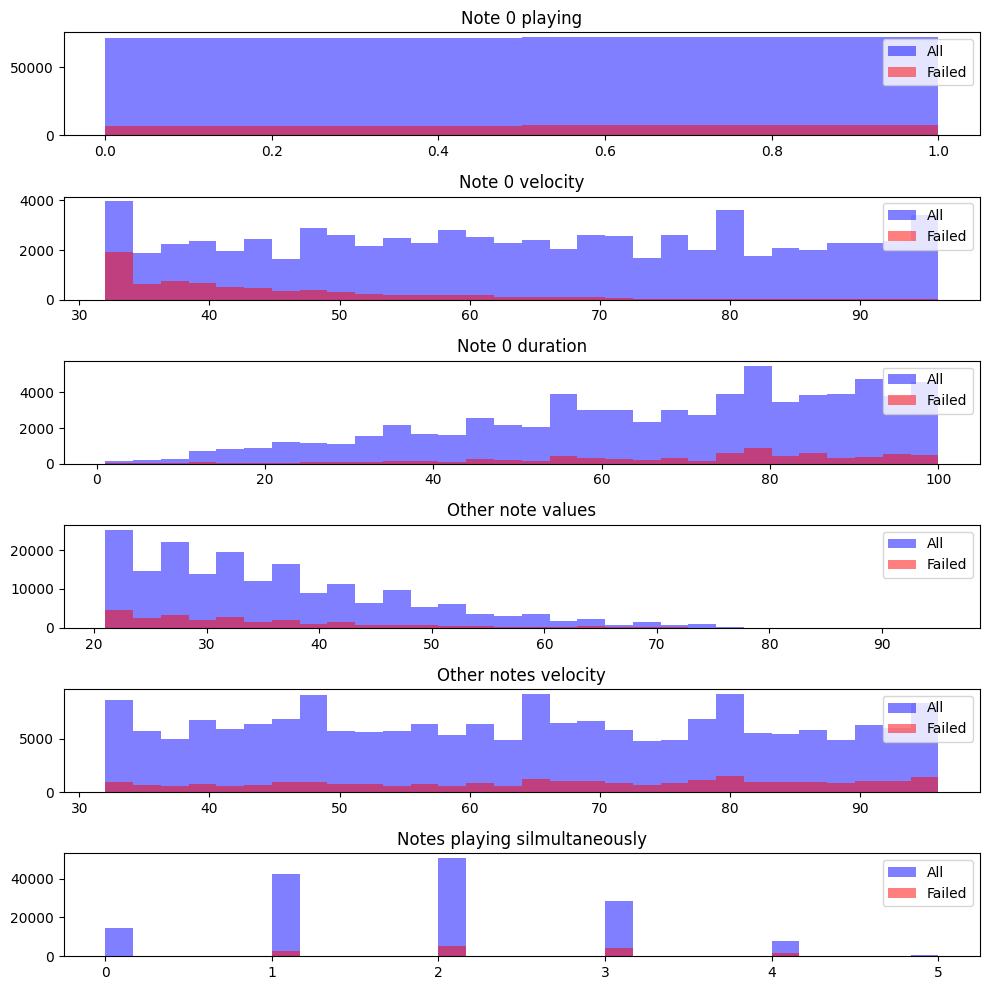

In [37]:
subplot_size = (6, 1)

note_cols = [f"note_{i}" for i in range(0, max_silmultaneous_notes)]
velocity_cols = [f"velocity_{i}" for i in range(0, max_silmultaneous_notes)]

def plot_comparison(title, func, bins=30):
    plt.title(title)
    plt.hist(func(val_notes_data), bins=bins, label="All", alpha=0.5, color="blue")
    plt.hist(func(misses_data), bins=bins, label="Failed", alpha=0.5, color="red")
    plt.legend(loc="upper right")


plt.figure(figsize=(10, 10))
plt.subplot(*subplot_size, 1)
plot_comparison("Note 0 playing", lambda df: ~df["note_0"].isna() * 1, bins=2)

plt.subplot(*subplot_size, 2)
plt.title("Note 0 velocity")
plot_comparison("Note 0 velocity", lambda df: df["velocity_0"].dropna())

plt.subplot(*subplot_size, 3)
plt.title("Note 0 duration")
plot_comparison("Note 0 duration", lambda df: df["duration_0"].dropna())

plt.subplot(*subplot_size, 4)
plot_comparison("Other note values", lambda df: df[note_cols[1:]].stack().values)

plt.subplot(*subplot_size, 5)
plot_comparison("Other notes velocity", lambda df: df[velocity_cols[1:]].stack().values)

plt.subplot(*subplot_size, 6)
plot_comparison("Notes playing silmultaneously", lambda df: (~df[note_cols].isna()).sum(axis=1))

plt.tight_layout()
plt.show()